# Baseline Models for Delay Prediction

Setting up naive and moving average baselines so there's a clear floor to compare the real models against. Also trying Prophet to see if it adds anything.

In [1]:
# imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.models.baselines import (
    NaiveBaseline, SeasonalNaiveBaseline, MovingAverageBaseline, ProphetModel
)
from src.evaluation.metrics import calculate_delay_metrics
from src.config import VAL_END

TARGET_COL = 'avg_arr_delay'

Importing plotly failed. Interactive plots will not work.


## Load Data

In [2]:
# load feature data
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

print(f'Total samples: {len(df):,}')
print(f'Routes: {df["route"].nunique()}')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')

Total samples: 47,460
Routes: 20
Date range: 2019-01-01 00:00:00 to 2025-06-30 00:00:00


## Train-Test Split

In [3]:
# split into train and test sets
train_end = pd.Timestamp(VAL_END)

train_df = df[df['date'] < train_end].copy()
test_df = df[df['date'] >= train_end].copy()

print(f'Train: {len(train_df):,} samples ({train_df["date"].min()} to {train_df["date"].max()})')
print(f'Test: {len(test_df):,} samples ({test_df["date"].min()} to {test_df["date"].max()})')

Train: 40,160 samples (2019-01-01 00:00:00 to 2024-06-30 00:00:00)
Test: 7,300 samples (2024-07-01 00:00:00 to 2025-06-30 00:00:00)


## Evaluate Baselines

In [4]:
# evaluate baseline models on test set
models = [
    NaiveBaseline(target_col=TARGET_COL),
    SeasonalNaiveBaseline(7, target_col=TARGET_COL),
    MovingAverageBaseline(7, target_col=TARGET_COL),
    MovingAverageBaseline(14, target_col=TARGET_COL),
    MovingAverageBaseline(28, target_col=TARGET_COL)
]

results = []

for model in models:
    print(f'Evaluating {model.name}...')
    
    model.fit(train_df)
    
    full_df = pd.concat([train_df, test_df]).sort_values(['route', 'date'])
    predictions = model.predict(full_df)
    
    test_preds = predictions.loc[test_df.index]
    test_actuals = test_df[TARGET_COL]
    
    metrics = calculate_delay_metrics(test_actuals.values, test_preds.values)
    metrics['model'] = model.name
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df[['model', 'mae', 'rmse', 'within_15', 'directional', 'r2']]

Evaluating Naive...
Evaluating SeasonalNaive_7...
Evaluating MovingAverage_7...
Evaluating MovingAverage_14...
Evaluating MovingAverage_28...


,model,mae,rmse,within_15,directional,r2
0,Naive,16.125797,26.531593,65.767123,76.356164,-0.162311
1,SeasonalNaive_7,19.343989,31.487743,59.561644,70.479452,-0.637114
2,MovingAverage_7,14.973669,23.738698,66.493151,74.273973,0.069515
3,MovingAverage_14,14.871502,23.329824,65.958904,74.287671,0.101292
4,MovingAverage_28,14.864208,23.367672,66.246575,75.027397,0.098374


## Prophet Model

In [5]:
# train and evaluate Prophet model
print('Training Prophet model')

prophet = ProphetModel(add_holidays=True, target_col=TARGET_COL)
prophet.fit(train_df)

prophet_preds = prophet.predict(test_df)
prophet_metrics = calculate_delay_metrics(test_df[TARGET_COL].values, prophet_preds.values)
prophet_metrics['model'] = 'Prophet'

results.append(prophet_metrics)
results_df = pd.DataFrame(results)
results_df[['model', 'mae', 'rmse', 'within_15', 'directional', 'r2']]

Training Prophet model


14:05:01 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing
14:05:04 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing
14:05:04 - cmdstanpy - INFO - Chain [1] start processing
14:05:05 - cmdstanpy - INFO - Chain [1] done processing
14:05:05 - cmdstanpy - INFO - Chain [1] start processing
14:05:05 - cmdstanpy - INFO - Chain [1]

,model,mae,rmse,within_15,directional,r2
0,Naive,16.125797,26.531593,65.767123,76.356164,-0.162311
1,SeasonalNaive_7,19.343989,31.487743,59.561644,70.479452,-0.637114
2,MovingAverage_7,14.973669,23.738698,66.493151,74.273973,0.069515
3,MovingAverage_14,14.871502,23.329824,65.958904,74.287671,0.101292
4,MovingAverage_28,14.864208,23.367672,66.246575,75.027397,0.098374
5,Prophet,15.733560,23.729890,61.753425,72.397260,0.070205


## Visualize Results

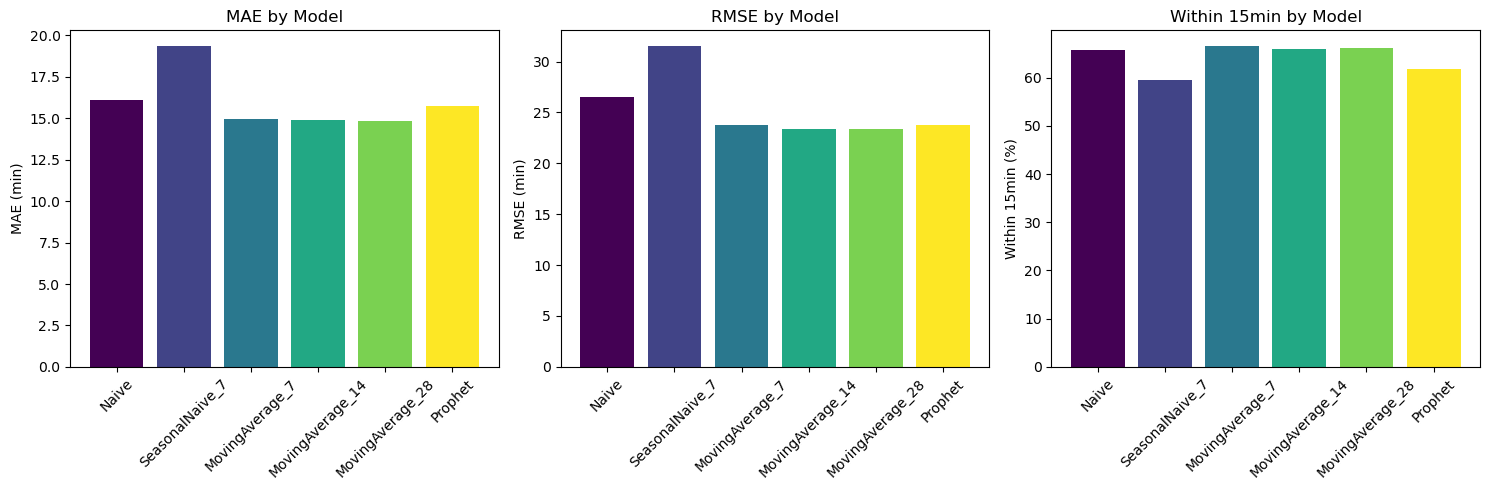

In [6]:
# compare baseline performance across metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))

ax1.bar(results_df['model'], results_df['mae'], color=colors)
ax1.set_ylabel('MAE (min)')
ax1.set_title('MAE by Model')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(results_df['model'], results_df['rmse'], color=colors)
ax2.set_ylabel('RMSE (min)')
ax2.set_title('RMSE by Model')
ax2.tick_params(axis='x', rotation=45)

ax3.bar(results_df['model'], results_df['within_15'], color=colors)
ax3.set_ylabel('Within 15min (%)')
ax3.set_title('Within 15min by Model')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Forecast Visualization

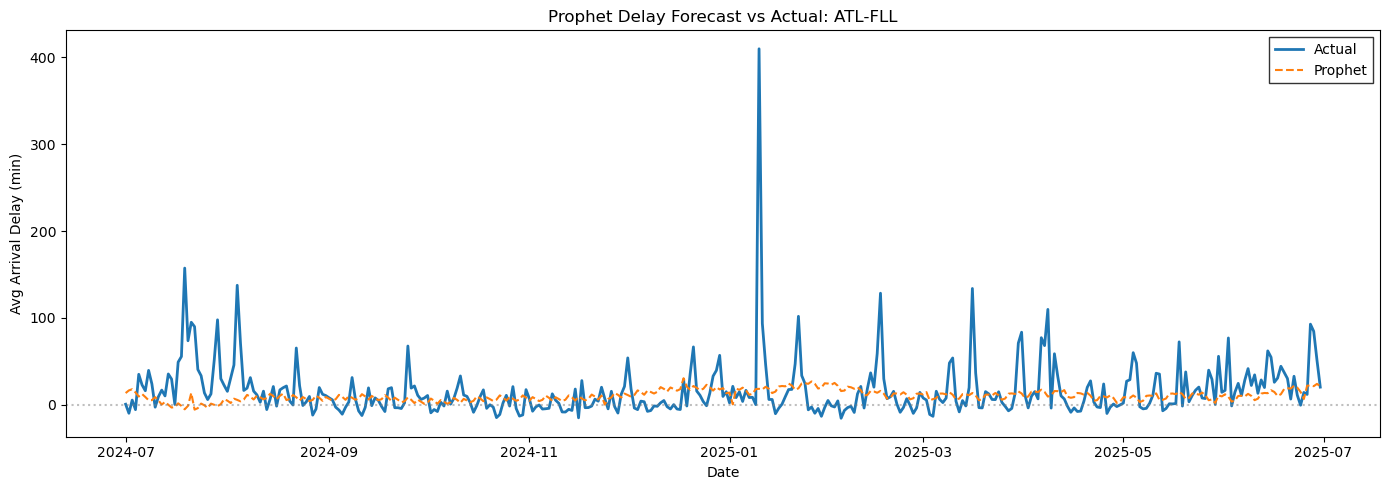

In [7]:
# visualize Prophet forecast vs actual for a sample route
sample_route = df['route'].unique()[0]

route_test = test_df[test_df['route'] == sample_route].copy()
route_test['prophet_pred'] = prophet_preds.loc[route_test.index].values

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(route_test['date'], route_test[TARGET_COL], label='Actual', linewidth=2)
ax.plot(route_test['date'], route_test['prophet_pred'], label='Prophet', linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Arrival Delay (min)')
ax.set_title(f'Prophet Delay Forecast vs Actual: {sample_route}')
ax.legend(frameon=True, edgecolor='black')
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

## Summary

The naive baseline gets about 16 min MAE, so yesterday's delay does tell you something about today's. Moving averages do a bit better, especially the 14-day and 28-day windows, which lines up with the weekly patterns from the EDA. Prophet doesn't really add anything over the moving averages.

My expectation going in is that tree-based models (XGBoost, LightGBM) will do better than deep learning (LSTM, TCN) on this kind of tabular data with engineered features. I wanted to try both approaches though, since the deep learning models work directly on sequences and might pick up on temporal patterns that explicit feature engineering misses.

**Next:** [04_xgboost_delay.ipynb](04_xgboost_delay.ipynb)